In this notebook, we will build a 3D map of a scene from a small set of images and then localize an image downloaded from the Internet. This demo was contributed by [Philipp Lindenberger](https://github.com/Phil26AT/).

In [2]:
import cv2
capture = cv2.VideoCapture("/home/unicorn/project/Hierarchical-Localization/datasets/My_lib_dataset/mapping5/654121250.mp4")

if(capture.isOpened()):
    i=0;
    while True:
        ret, prev = capture.read()
        if ret == True :
            if(i%10==0):
                cv2.imshow('video', prev)
                cv2.imwrite('/home/unicorn/project/Hierarchical-Localization/datasets/My_lib_dataset/mapping5/'+str(i)+'.jpg', prev);
        else:
            break
        if cv2.waitKey(20)==27:
            break
        i=i+1
cv2.destroyAllWindows()

In [3]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive, pairs_from_retrieval
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

# Setup
Here we define some output paths.

In [4]:
images = Path('datasets/My_lib_dataset')
outputs = Path('outputs/demo/')
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

retrieval_conf = extract_features.confs['netvlad']
feature_conf = extract_features.confs['superpoint_inloc']
matcher_conf = match_features.confs['superglue']

# 3D mapping
First we list the images used for mapping. These are all day-time shots of Sacre Coeur.

65 mapping images


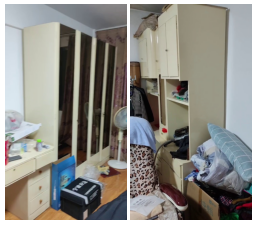

In [5]:
references = [p.relative_to(images).as_posix() for p in (images / 'mapping5/').iterdir()] # 获取mapping5文件夹下的所有图片
print(len(references), "mapping images") 
plot_images([read_image(images / r) for r in references[:2]], dpi=50)

In [6]:
retrieval_path = extract_features.main(retrieval_conf, images, outputs) # 使用netvlad提取局部特征，并保存在对应路径
pairs_from_retrieval.main(retrieval_path, sfm_pairs, num_matched=3) #输入局部特征路径，输出匹配图片到sfm_pairs

[2023/01/20 20:26:39 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2023/01/20 20:26:39 hloc INFO] Found 252 images in root datasets/My_lib_dataset.


  0%|          | 0/252 [00:00<?, ?it/s]

[2023/01/20 20:27:27 hloc INFO] Finished exporting features.
[2023/01/20 20:27:27 hloc INFO] Extracting image pairs from a retrieval database.
[2023/01/20 20:27:28 hloc INFO] Found 756 pairs.


Then we extract features and match them across image pairs. Since we deal with few images, we simply match all pairs exhaustively. For larger scenes, we would use image retrieval, as demonstrated in the other notebooks.

In [7]:
feature_path = extract_features.main(feature_conf, images, outputs) #使用superpoint重新提取特征
match_path = match_features.main(matcher_conf, sfm_pairs, feature_conf['output'], outputs, overwrite=True) #使用superglue匹配特征对
# feature_conf['output']是获取对应网络提取特征的输出文件名，与路径组合就能读取特征文件。

[2023/01/20 20:27:28 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 4},
 'output': 'feats-superpoint-n4096-r1600',
 'preprocessing': {'grayscale': True, 'resize_max': 1600}}
[2023/01/20 20:27:28 hloc INFO] Found 252 images in root datasets/My_lib_dataset.


Loaded SuperPoint model


  0%|          | 0/252 [00:00<?, ?it/s]

[2023/01/20 20:27:52 hloc INFO] Finished exporting features.
[2023/01/20 20:27:52 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


  0%|          | 0/471 [00:00<?, ?it/s]

[2023/01/20 20:31:55 hloc INFO] Finished exporting matches.


The we run incremental Structure-From-Motion and display the reconstructed 3D model.

In [8]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, feature_path, match_path) #运用图片信息、特征信息和特征匹配对信息进行三维重建
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping")
fig.show()

[2023/01/20 20:32:11 hloc INFO] Creating an empty database...
[2023/01/20 20:32:11 hloc INFO] Importing images into the database...
[2023/01/20 20:32:15 hloc INFO] Importing features into the database...


  0%|          | 0/252 [00:00<?, ?it/s]

[2023/01/20 20:32:15 hloc INFO] Importing matches into the database...


  0%|          | 0/756 [00:00<?, ?it/s]

[2023/01/20 20:32:15 hloc INFO] Performing geometric verification of the matches...
[2023/01/20 20:32:19 hloc INFO] Running 3D reconstruction...
W0120 20:32:50.852079 13334 levenberg_marquardt_strategy.cc:116] Linear solver failure. Failed to compute a step: Eigen failure. Unable to perform dense Cholesky factorization.
W0120 20:32:50.862588 13334 levenberg_marquardt_strategy.cc:116] Linear solver failure. Failed to compute a step: Eigen failure. Unable to perform dense Cholesky factorization.
W0120 20:32:50.865563 13334 levenberg_marquardt_strategy.cc:116] Linear solver failure. Failed to compute a step: Eigen failure. Unable to perform dense Cholesky factorization.
W0120 20:33:00.805522 13334 levenberg_marquardt_strategy.cc:116] Linear solver failure. Failed to compute a step: Eigen failure. Unable to perform dense Cholesky factorization.
W0120 20:33:00.806993 13334 levenberg_marquardt_strategy.cc:116] Linear solver failure. Failed to compute a step: Eigen failure. Unable to perform 

We also visualize which keypoints were triangulated into the 3D model.

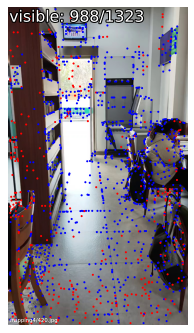

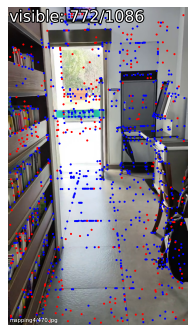

In [42]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=2)

# Localization
Now that we have a 3D map of the scene, we can localize any image. To demonstrate this, we download [a night-time image from Wikimedia](https://commons.wikimedia.org/wiki/File:Paris_-_Basilique_du_Sacr%C3%A9_Coeur,_Montmartre_-_panoramio.jpg).

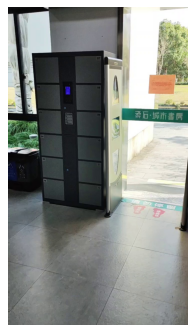

In [47]:
# url = "https://upload.wikimedia.org/wikipedia/commons/5/53/Paris_-_Basilique_du_Sacr%C3%A9_Coeur%2C_Montmartre_-_panoramio.jpg"
# try other queries by uncommenting their url
# url = "https://upload.wikimedia.org/wikipedia/commons/5/59/Basilique_du_Sacr%C3%A9-C%C5%93ur_%285430392880%29.jpg"
# url = "https://upload.wikimedia.org/wikipedia/commons/8/8e/Sacr%C3%A9_C%C5%93ur_at_night%21_%285865355326%29.jpg"
# query = 'query/night.jpg'

query = 'query/mapping3540.jpg'
# !mkdir -p $images/query && wget $url -O $images/$query -q
plot_images([read_image(images / query)], dpi=75)

Again, we extract features for the query and match them exhaustively.

In [48]:
extract_features.main(feature_conf, images, image_list=[query], feature_path=features, overwrite=True)
pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references)
match_features.main(matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True);

[2023/01/18 13:46:29 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Loaded SuperPoint model


  0%|          | 0/1 [00:00<?, ?it/s]

[2023/01/18 13:46:29 hloc INFO] Finished exporting features.
[2023/01/18 13:46:29 hloc INFO] Found 93 pairs.
[2023/01/18 13:46:29 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


  0%|          | 0/93 [00:00<?, ?it/s]

[2023/01/18 13:46:47 hloc INFO] Finished exporting matches.


We read the EXIF data of the query to infer a rough initial estimate of camera parameters like the focal length. Then we estimate the absolute camera pose using PnP+RANSAC and refine the camera parameters.

In [49]:
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [model.find_image_with_name(r).image_id for r in references]
conf = {
    'estimation': {'ransac': {'max_error': 12}},
    'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches)

print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, model)

AttributeError: 'NoneType' object has no attribute 'image_id'

: 

We visualize the correspondences between the query images a few mapping images. We can also visualize the estimated camera pose in the 3D map.

In [11]:
pose = pycolmap.Image(tvec=ret['tvec'], qvec=ret['qvec'])
viz_3d.plot_camera_colmap(fig, pose, camera, color='rgba(0,255,0,0.5)', name=query)
fig.show()